# This is the Exploratory Data Analysis of the LDA data for bike sharing.

In [1]:
import os
import datetime
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="paper", font="monospace")

%matplotlib inline

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

import scipy.stats as stats

## Import data and data cleansing

In [2]:
df = pd.read_csv("GDA DATA.csv")
print(df.shape)#Get the matrix info of the df.
df.head()

(171792, 11)


,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code
0,432946,406,8/31/2014 22:31,Mountain View Caltrain Station,28,8/31/2014 22:38,Castro Street and El Camino Real,32,17,Subscriber,94040
1,432945,468,8/31/2014 22:07,Beale at Market,56,8/31/2014 22:15,Market at 4th,76,509,Customer,11231
2,432944,534,8/31/2014 22:06,Beale at Market,56,8/31/2014 22:15,Market at 4th,76,342,Customer,11231
3,432942,1041,8/31/2014 21:45,Embarcadero at Sansome,60,8/31/2014 22:02,Steuart at Market,74,603,Customer,94521
4,432941,1091,8/31/2014 21:44,Embarcadero at Sansome,60,8/31/2014 22:02,Steuart at Market,74,598,Customer,94521


In [3]:
#Check for missing values. Zip Codes are missing a lot. Even it's not missing, it seems that there are a lot of incorrect ones.
df.isnull().sum()

Trip ID              0
Duration             0
Start Date           0
Start Station        0
Start Terminal       0
End Date             0
End Station          0
End Terminal         0
Bike #               0
Subscriber Type      0
Zip Code           211
dtype: int64

In [4]:
df.dtypes

Trip ID             int64
Duration            int64
Start Date         object
Start Station      object
Start Terminal      int64
End Date           object
End Station        object
End Terminal        int64
Bike #              int64
Subscriber Type    object
Zip Code           object
dtype: object

The "Start Date" and the "End Date" are objects mixed with dates and times. We can split them to make it easier to analyze.

In [5]:
df1 = df.rename(columns={'Start Date': 'Start_Date', 'End Date': 'End_Date'})
df1.Start_Date = pd.to_datetime(df1.Start_Date, format='%m/%d/%Y %H:%M')
df1.End_Date = pd.to_datetime(df1.End_Date, format='%m/%d/%Y %H:%M')

## Feature engineering on datetime variables

In [23]:
df1['S_Date'] = pd.to_datetime(df1['Start_Date'].dt.date)
df1['S_Time'] = df1['Start_Date'].dt.time #hours and minutes
df1['S_wknum'] = df1['Start_Date'].dt.dayofweek #days' names
df1['S_wkd'] = df1['Start_Date'].dt.weekday_name #days' numbers in one week
df1['S_mdnum'] = df1['Start_Date'].dt.day #days' numbers in one month
df1['S_mon'] = df1['Start_Date'].dt.month # months' numbers in one year
df1['S_dh'] = df1['Start_Date'].dt.hour #hours' numbers in one day
df1['S_YearMonth'] = df1['Start_Date'].map(lambda x: 100*x.year + x.month) # months & years' of the start time

df1['E_Date'] = pd.to_datetime(df1['End_Date'].dt.date)
df1['E_Time'] = df1['End_Date'].dt.time
df1['E_wknum'] = df1['End_Date'].dt.dayofweek
df1['E_wkd'] = df1['End_Date'].dt.weekday_name
df1['E_mdnum'] = df1['End_Date'].dt.day
df1['E_mon'] = df1['End_Date'].dt.month
df1['E_dh'] = df1['End_Date'].dt.hour

df1.head()

,Trip ID,Duration,Start_Date,Start Station,Start Terminal,End_Date,End Station,End Terminal,Bike #,Subscriber Type,...,S_dh,S_YearMonth,E_Date,E_Time,E_wknum,E_wkd,E_mdnum,E_mon,E_dh,is_duplicated
0,432946,6.766667,2014-08-31 22:31:00,Mountain View Caltrain Station,28,2014-08-31 22:38:00,Castro Street and El Camino Real,32,17,Subscriber,...,22,201408,2014-08-31,22:38:00,6,Sunday,31,8,22,False
1,432945,7.800000,2014-08-31 22:07:00,Beale at Market,56,2014-08-31 22:15:00,Market at 4th,76,509,Customer,...,22,201408,2014-08-31,22:15:00,6,Sunday,31,8,22,False
2,432944,8.900000,2014-08-31 22:06:00,Beale at Market,56,2014-08-31 22:15:00,Market at 4th,76,342,Customer,...,22,201408,2014-08-31,22:15:00,6,Sunday,31,8,22,False
3,432942,17.350000,2014-08-31 21:45:00,Embarcadero at Sansome,60,2014-08-31 22:02:00,Steuart at Market,74,603,Customer,...,21,201408,2014-08-31,22:02:00,6,Sunday,31,8,22,False
4,432941,18.183333,2014-08-31 21:44:00,Embarcadero at Sansome,60,2014-08-31 22:02:00,Steuart at Market,74,598,Customer,...,21,201408,2014-08-31,22:02:00,6,Sunday,31,8,22,False


According to the start time and the end time, it seems that the Duration variable is in the unit of second. 
We can convert it into minutes.

In [7]:
df1.Duration /= 60
df1.Duration.describe()

count    171792.000000
mean         18.875237
std         101.403916
min           1.000000
25%           5.750000
50%           8.616667
75%          12.683333
max       11941.333333
Name: Duration, dtype: float64

The average of the trip is 18.87 minutes long.

In [8]:
# Check duplicated rows. I added a flag called "is_duplicated" to indentify the dups.
df2 = df1
df2['is_duplicated'] = df2.duplicated()
dup_sum = df2['is_duplicated'].sum()
dup_df = df2[df2.is_duplicated == 1] # Output the  duplicational dataframe.
print ("There are {0} duplications in the dataset.".format(dup_sum))
dup_df

There are 0 duplications in the dataset.


,Trip ID,Duration,Start_Date,Start Station,Start Terminal,End_Date,End Station,End Terminal,Bike #,Subscriber Type,...,S_dh,S_YearMonth,E_Date,E_Time,E_wknum,E_wkd,E_mdnum,E_mon,E_dh,is_duplicated


## Visualization based on time frames

We can visualize the number of deliveries grouping by different time frames.

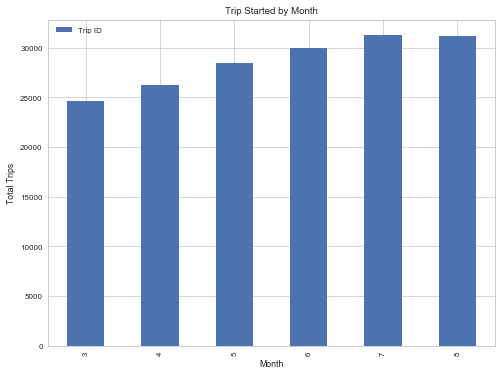

In [24]:
df2_month = df2.pivot_table(index=['S_mon'],
                                  values='Trip ID',
                                  aggfunc='count')
df2_month.plot(kind='bar', figsize=(8,6))
plt.xlabel('Month')
plt.ylabel('Total Trips')
plt.title('Trip Started by Month');


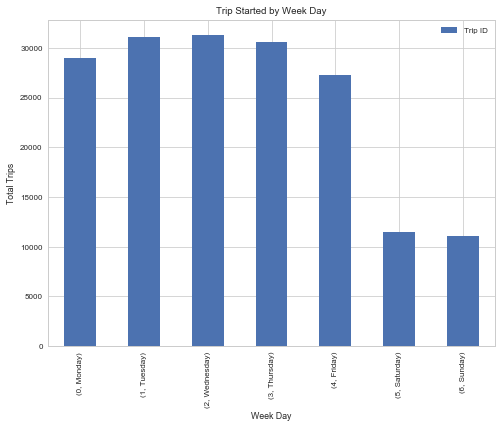

In [25]:
df2_weekdays = df2.pivot_table(index=['S_wknum','S_wkd'],
                                  values='Trip ID',
                                  aggfunc='count')
df2_weekdays.plot(kind='bar', figsize=(8,6))
plt.xlabel('Week Day')
plt.ylabel('Total Trips')

plt.title('Trip Started by Week Day');



Weekdays have equally high volume of trips. It's weird that we might arbitrarily think the 
shared bikes might have higher needs on weekends because people want to get rid of driving in the heavy traffic on weekends. It seems that people might use shared bike for commuting more. 

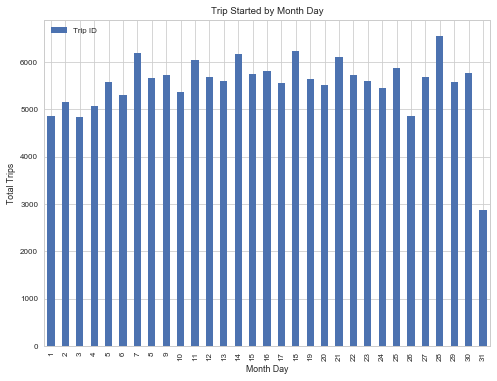

In [26]:
# We can explore if there is a latent pattern for each day in a month.

df2_monthdays = df2.pivot_table(index=['S_mdnum'],
                                  values='Trip ID',
                                  aggfunc='count')
df2_monthdays.plot(kind='bar', figsize=(8,6))
plt.xlabel('Month Day')
plt.ylabel('Total Trips')
plt.title('Trip Started by Month Day');

# There is no known pattern for the month_day barchart except that 31st has the lowest counts.

We can explore starting hours and ending hours of trips.

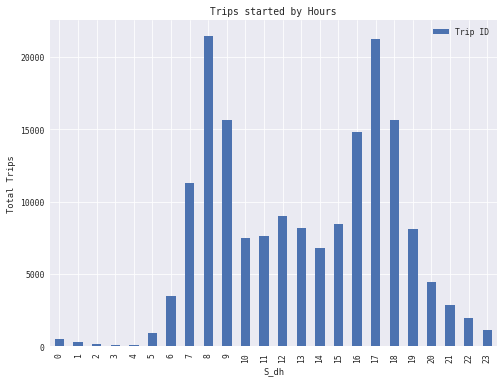

In [12]:
# Now it's the time for hours' distribution.

df2_shours = df2.pivot_table(index=['S_dh'],
                                  values='Trip ID',
                                  aggfunc='count')
df2_shours.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Trips')
plt.title('Trips started by Hours');


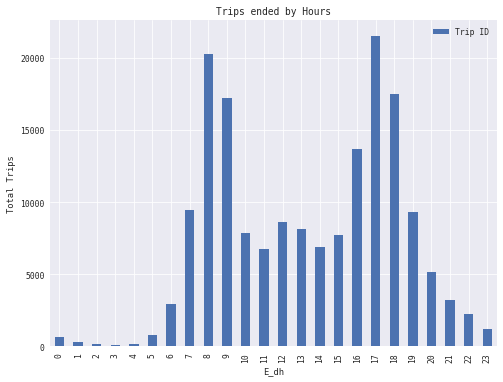

In [13]:
df2_ehours = df2.pivot_table(index=['E_dh'],
                                  values='Trip ID',
                                  aggfunc='count')
df2_ehours.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Trips')
plt.title('Trips ended by Hours');

We can figure out that peak hours are in commuting hours. The distrition of the starting hours and ending hours are almost the same, which valids that the lengh of most of trips are less than one hour. (The average lengh is 18.87 mins as we saw before)

In [14]:
#Let's do some pivot research. We can group the data by Weekday and hour
ssummary = df2.groupby(['S_wkd', 'S_dh'])['Trip ID'].count()
#reset index
ssummary = ssummary.reset_index()
#convert to dataframe
ssummary = pd.DataFrame(ssummary)
#browse data
#rename last column
ssummary=ssummary.rename(columns = {'Trip ID':'Trip_Counts', \
                                  'S_dh' : 'start_hours', 'S_wkd' : 'start_weekdays'}) 
ssummary.head()

,start_weekdays,start_hours,Trip_Counts
0,Friday,0,79
1,Friday,1,37
2,Friday,2,20
3,Friday,3,12
4,Friday,4,20


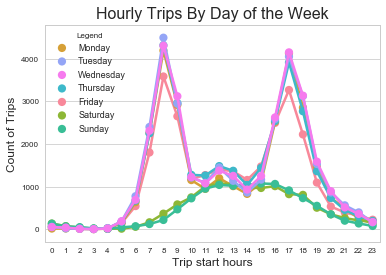

In [27]:
#Now visualize it.
sns.set_style('whitegrid')
ax = sns.pointplot(x="start_hours", y="Trip_Counts", hue="start_weekdays", data=ssummary)
handles,labels = ax.get_legend_handles_labels()
#reordering legend content
handles = [handles[1], handles[5], handles[6], handles[4], handles[0], handles[2], handles[3]]
labels = [labels[1], labels[5], labels[6], labels[4], labels[0], labels[2], labels[3]]
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel('Trip start hours', fontsize = 12)
ax.set_ylabel('Count of Trips', fontsize = 12)
ax.set_title('Hourly Trips By Day of the Week', fontsize=16)
ax.tick_params(labelsize = 8)
ax.legend(handles,labels,loc=0, title="Legend", prop={'size':9})
ax.get_legend().get_title().set_fontsize('8')
plt.show()



Now we can easlily see that Sundays and Saturdays are having different patterns from weekdays. Weekdays have to significant peaks(M shape), while weekends have a bell shape.

## Visualization by operations

We want to have an intuition of types of riders. We can see if subscribers use shared bikes more or random customers use them more. There are two types of riders: Random customers and subscribers. We want to increase the base of subscribers because they may bring steady cash flow to the company. We also want to track the subscribers' engagement(activeness) and the retention/growth/churn rates.

In [16]:
#Create a table containing trip coutns grouping by time and the entity type.

ridersummary = df2.groupby(['S_YearMonth', 'Subscriber Type'])['Trip ID'].count()
ridersummary = ridersummary.reset_index()
ridersummary = pd.DataFrame(ridersummary)

ridersummary=ridersummary.rename(columns = {'Trip ID':'Trip_Counts', \
                                  'S_YearMonth' : 'start_year&month', 'Subscriber Type' : 'subscriber_type'}) 
ridersummary.head()

,start_year&month,subscriber_type,Trip_Counts
0,201403,Customer,4009
1,201403,Subscriber,20584
2,201404,Customer,4083
3,201404,Subscriber,22138
4,201405,Customer,5125


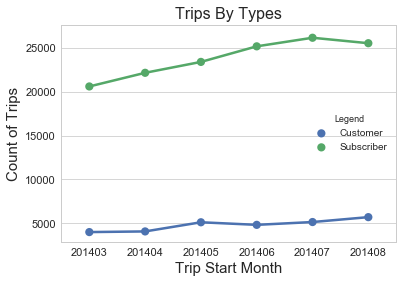

In [17]:
sns.set_style('whitegrid')
ax = sns.pointplot(x="start_year&month", y="Trip_Counts", hue="subscriber_type", data=ridersummary)
handles,labels = ax.get_legend_handles_labels()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel('Trip Start Month', fontsize = 15)
ax.set_ylabel('Count of Trips', fontsize = 15)
ax.set_title('Trips By Types', fontsize=16)
ax.tick_params(labelsize = 11)
ax.legend(handles,labels,loc=0, title="Legend", prop={'size':10})
ax.get_legend().get_title().set_fontsize('9')
plt.figure(figsize=(5,3))
plt.show()

There is a little conern of subscribers' engagement in August 2014. There are several possbilities: Subscribers are churning, seasonality, competitors' stretegies, etc.

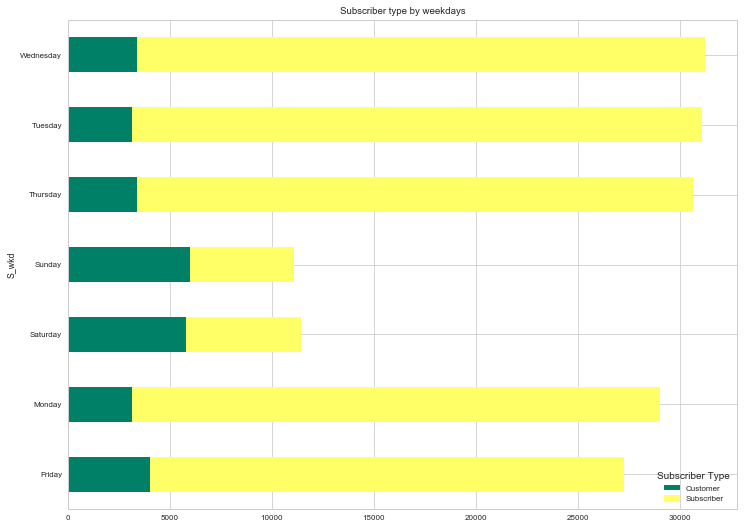

In [18]:
group_by_wkd = df1.groupby(['S_wkd','Subscriber Type'])
en_type_wkd = group_by_wkd.size().unstack()
en_type_wkd.plot(kind = 'barh', stacked = True, 
                 figsize = [12,9], colormap = 'summer', title = 'Subscriber type by weekdays')

We surprisingly found that on weekdays, subscribers predominate the whole rider group. Rather, on weekends, random customers and subscribers are more equal. Even customers are slightly more than subscribers.

In [19]:
#Top 5 subscribers' zipcodes
s_hi = df1['Zip Code'].value_counts()[:5]
s_hi

94107    16179
94105    10337
94133     8157
94103     6434
94111     5742
Name: Zip Code, dtype: int64

We can see most of our subscribers are from 94107(Mission Bay/Dogpatch/Petero Hill), 94105(South Beach), 94133(North Beach/Russian Hill), 94103(SoMa), 94111(Financial District).

## Visualization by geo_info

Because the lack of longitude and latitude, I can't easily map the trips on a real map. I wish I can have this info in the future.

We can find out the top 10 busiest stations during the morning & evening peak hours.

San Francisco Caltrain (Townsend at 4th)         29682
Harry Bridges Plaza (Ferry Building)             16244
Embarcadero at Sansome                           15151
Market at Sansome                                14698
San Francisco Caltrain 2 (330 Townsend)          14490
2nd at Townsend                                  14235
Steuart at Market                                12566
Temporary Transbay Terminal (Howard at Beale)    12298
Townsend at 7th                                  11621
Market at 4th                                    10362
dtype: int64


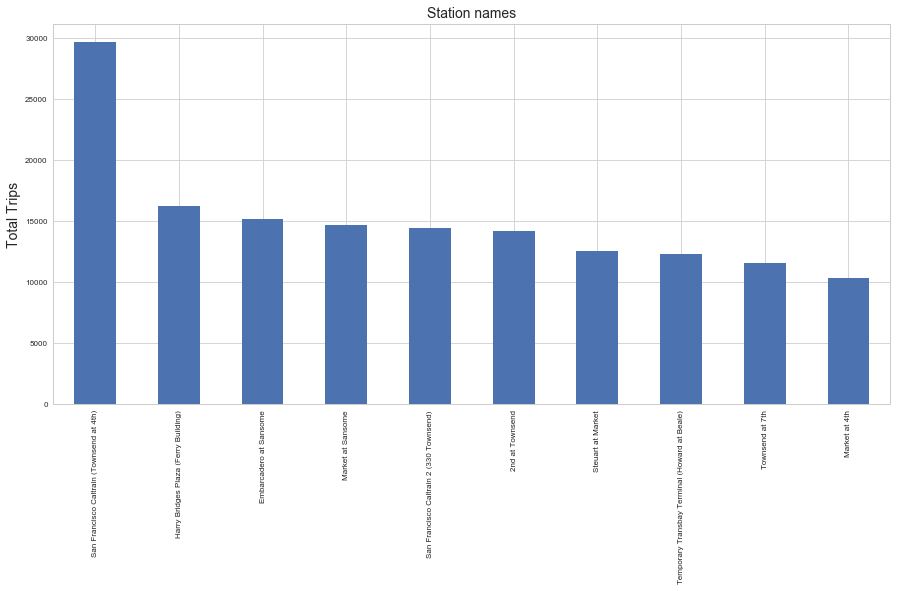

In [20]:
#Overall stats
hi_volume = df1[['Start Station', 'End Station']].stack().value_counts()[:10]
hi_volume.plot(kind='bar', figsize=(15,7))
plt.ylabel('Total Trips', fontsize=14)
plt.title('Station names', fontsize=14)
print(hi_volume)

Morning peak stations.

In [28]:
m_p = (7,8,9) #Create a list of morning peak hours.
morning_start_hi = df1[df1['S_dh'].isin(m_p)]
m_s_h = morning_start_hi['Start Station'].value_counts()[:10]
morning_end_hi = df1[df1['E_dh'].isin(m_p)]
m_e_h = morning_end_hi['End Station'].value_counts()[:10]
morning_peak_stations = pd.concat([m_s_h, m_e_h], axis = 1) #Combining start station and end station together to compare.
print(m_s_h)
print(m_e_h)
morning_peak_stations

San Francisco Caltrain (Townsend at 4th)         7101
San Francisco Caltrain 2 (330 Townsend)          3518
Temporary Transbay Terminal (Howard at Beale)    3346
Harry Bridges Plaza (Ferry Building)             3134
Steuart at Market                                2243
Grant Avenue at Columbus Avenue                  1750
2nd at Townsend                                  1683
Market at Sansome                                1431
Beale at Market                                  1374
Civic Center BART (7th at Market)                1327
Name: Start Station, dtype: int64
San Francisco Caltrain (Townsend at 4th)         3652
2nd at Townsend                                  2712
Market at Sansome                                2575
Townsend at 7th                                  2226
Embarcadero at Folsom                            1712
Embarcadero at Sansome                           1664
2nd at South Park                                1654
Temporary Transbay Terminal (Howard at Beale)   

,Start Station,End Station
2nd at South Park,NaN,1654.0
2nd at Townsend,1683.0,2712.0
Beale at Market,1374.0,NaN
Civic Center BART (7th at Market),1327.0,NaN
Embarcadero at Folsom,NaN,1712.0
Embarcadero at Sansome,NaN,1664.0
Grant Avenue at Columbus Avenue,1750.0,NaN
Harry Bridges Plaza (Ferry Building),3134.0,NaN
Market at Sansome,1431.0,2575.0
San Francisco Caltrain (Townsend at 4th),7101.0,3652.0


We can see some people are starting their trips from transit hubs like Caltrain station, Ferry terminals and the Transbay Terminal connecting to the East bay, and then stop their trips at Financial District. We can all them "Inbound commuters" because they live outside of the downtown and work in the downtown. Vise versa, people who live's in the downtown but work outside of the city, which we can call them "Outbound commuters". Outbound commuters are also contributing to the morning peak hours because they also travel to the public transit hubs.

Evening peak stations.

In [29]:
e_p = (16,17,18) #Create a list of evening peak hours.
evening_start_hi = df1[df1['S_dh'].isin(e_p)]
e_s_h = evening_start_hi['Start Station'].value_counts()[:10]
evening_end_hi = df1[df1['E_dh'].isin(e_p)]
e_e_h = evening_end_hi['End Station'].value_counts()[:10]
evening_peak_stations = pd.concat([e_s_h, e_e_h], axis = 1)#Combining start station and end station together to compare.
print(m_s_h)
print(e_s_h)
print(e_e_h)
evening_peak_stations

San Francisco Caltrain (Townsend at 4th)         7101
San Francisco Caltrain 2 (330 Townsend)          3518
Temporary Transbay Terminal (Howard at Beale)    3346
Harry Bridges Plaza (Ferry Building)             3134
Steuart at Market                                2243
Grant Avenue at Columbus Avenue                  1750
2nd at Townsend                                  1683
Market at Sansome                                1431
Beale at Market                                  1374
Civic Center BART (7th at Market)                1327
Name: Start Station, dtype: int64
Embarcadero at Sansome                           2536
2nd at Townsend                                  2428
San Francisco Caltrain (Townsend at 4th)         2384
Market at Sansome                                2282
Townsend at 7th                                  2205
2nd at South Park                                1892
Steuart at Market                                1817
Market at 4th                                   

,Start Station,End Station
2nd at South Park,1892.0,NaN
2nd at Townsend,2428.0,1750.0
Embarcadero at Sansome,2536.0,2155.0
Harry Bridges Plaza (Ferry Building),NaN,3224.0
Market at 10th,1668.0,NaN
Market at 4th,1779.0,NaN
Market at Sansome,2282.0,2021.0
Powell Street BART,NaN,1647.0
San Francisco Caltrain (Townsend at 4th),2384.0,8961.0
San Francisco Caltrain 2 (330 Townsend),NaN,4048.0


Inversely from morning peak hours, we can see inbound commuters are starting their trips from the office(FiDi) to transit hubs. And outbound commuters are starting their trips from hubs to their sweet homes. 